In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd

show_head = True

In [2]:
gdf = gpd.read_file('/app/data/input/09CLBB_Predios_SII_Costanera')
gdf['Destino'] = gdf['Destino'].fillna('NO INFORMADO')
gdf['area_predio'] = gdf.area
if show_head: display(gdf.head(3))

,Destino,Rol,Avaluo,geometry,area_predio
0,SITIO ERIAZO,1392-2,1.091677e+09,"POLYGON ((671840.723 5922742.217, 671776.826 5...",27346.338208
1,SITIO ERIAZO,95000-17,3.038130e+08,"POLYGON ((672354.137 5923064.083, 672358.106 5...",10492.917473
2,BIENES COMUNES,1380-90001,4.516303e+08,"POLYGON ((671968.972 5922686.292, 671968.972 5...",2466.607737


In [3]:
grid = gpd.read_file('/app/data/input/grilla')
grid['area_grid'] = grid.area
if show_head: display(grid.head(3))

,id,left,top,right,bottom,grid_id,geometry,area_grid
0,930.0,136684.421725,5.917619e+06,136734.421725,5.917569e+06,1,"POLYGON ((671290.254 5923065.563, 671335.202 5...",2535.513020
1,931.0,136684.421725,5.917569e+06,136734.421725,5.917519e+06,2,"POLYGON ((671312.952 5923020.615, 671357.900 5...",2535.512694
2,932.0,136684.421725,5.917519e+06,136734.421725,5.917469e+06,3,"POLYGON ((671335.651 5922975.667, 671380.598 5...",2535.512367


In [4]:
intersection = gpd.overlay(grid, gdf, how='intersection')
intersection['area'] = intersection.area
if show_head: display(intersection.head(3))

,id,left,top,right,bottom,grid_id,area_grid,Destino,Rol,Avaluo,area_predio,geometry,area
0,1322.0,136934.421725,5.917269e+06,136984.421725,5.917219e+06,343,2535.511750,SITIO ERIAZO,1392-2,1.091677e+09,27346.338208,"POLYGON ((671741.527 5922842.171, 671732.927 5...",5.256147
1,1323.0,136934.421725,5.917219e+06,136984.421725,5.917169e+06,344,2535.511423,SITIO ERIAZO,1392-2,1.091677e+09,27346.338208,"POLYGON ((671741.527 5922842.171, 671757.492 5...",182.561854
2,1399.0,136984.421725,5.917269e+06,137034.421725,5.917219e+06,410,2535.511953,SITIO ERIAZO,1392-2,1.091677e+09,27346.338208,"POLYGON ((671741.527 5922842.171, 671741.035 5...",48.336810


In [5]:
inter_cols = ['grid_id', 'Destino', 'area', 'area_grid', 'area_predio']
intersection = intersection[inter_cols]
if show_head: display(intersection.head(3))

,grid_id,Destino,area,area_grid,area_predio
0,343,SITIO ERIAZO,5.256147,2535.511750,27346.338208
1,344,SITIO ERIAZO,182.561854,2535.511423,27346.338208
2,410,SITIO ERIAZO,48.336810,2535.511953,27346.338208


In [6]:
total_inter_area = intersection.groupby(['grid_id'])['area'].agg('sum').reset_index().rename(columns={'area': 'inter_area'})
if show_head: display(total_inter_area.sort_values(by=['inter_area'], ascending=False).head(3))

,grid_id,inter_area
393,1226,2535.610251
573,1484,2535.514552
386,1219,2535.512758


In [7]:
intersection = pd.merge(intersection, total_inter_area, on='grid_id')
if show_head: display(intersection.head(3))

,grid_id,Destino,area,area_grid,area_predio,inter_area
0,343,SITIO ERIAZO,5.256147,2535.511750,27346.338208,5.256147
1,344,SITIO ERIAZO,182.561854,2535.511423,27346.338208,182.561854
2,410,SITIO ERIAZO,48.336810,2535.511953,27346.338208,48.336810


In [8]:
intersection['property_percentage'] = intersection['area']/intersection['inter_area']

In [14]:
intersection['information_per_property'] = -1*intersection['property_percentage']*np.log10(intersection['property_percentage'])
diversity = intersection.groupby('grid_id')['information_per_property'].agg('sum').reset_index()

In [20]:
diversity_map = pd.merge(diversity, grid, on='grid_id')
diversity_map.rename(columns={'information_per_property': 'diversity'}, inplace=True)

diversity_map = gpd.GeoDataFrame(data=diversity_map['diversity'], geometry=diversity_map['geometry'])

<Axes: >

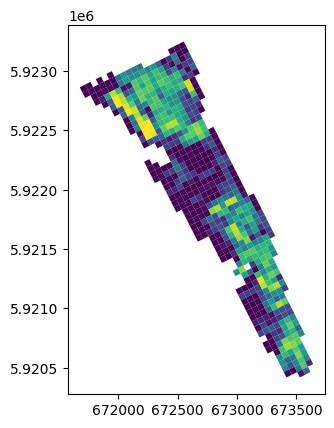

In [21]:
diversity_map.plot(column='diversity')